# Summary
Find the velocity path of movements. Velocity is calculated as the difference of consecutive points with a moving average filter of about 5 ms (29 samples).

__cutoff frequency of a moving average filter__:
for a moving average filter, $H(w) = \frac{1}{N} | \frac{\sin(wN/2)}{\sin(w/2)} | =0.5= -3 \text{dB}$

where $w = 2\pi \frac{f_\text{cutoff}}{f_\text{sample}}$ and $N=$ num samples per window

This analysis assumes foreperiod and reaction time after tone are always more than 7.5 ms.

### imports and plot settings:

In [43]:
from scipy import io
import numpy as np
import matplotlib.pyplot as plt
import statistics
import pandas as pd
import scipy.signal as signal
import scipy.interpolate as interpolate
import pickle
import glob # find files in a directory
import re # regex for string parsing

In [44]:
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['font.size'] = 14
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['figure.figsize'] = (5, 4)
plt.rcParams["figure.autolayout"] = True

### set `folder_name` and `day`

In [45]:
name = 'ANB1'
session = '20231102_d7'
trial_i_to_start = 0
num_trials = 276

In [46]:
tone_discriminiation_mat_file = '../Data_Copy/ToneDiscrimination/'+name+'/ToneDisc_'+name+'_'+session+'.mat'
analysis0_folder = "../Data_Copy/AnalysisData/"+name+"/analysis0_"+name+"_"+session+"/"
analysis1_folder = "../Data_Copy/AnalysisData/"+name+"/analysis1_"+name+"_"+session+"/"
output_folder = "../Data_Copy/AnalysisData/"+name+"/analysis5_"+name+"_"+session+"/"

for mac:

In [47]:
!mkdir {output_folder}

for windows:

In [48]:
!mkdir "{output_folder}"

mkdir: ../Data_Copy/AnalysisData/ANB1/analysis5_ANB1_20231102_d7/: File exists


### Define a helper function to find the moving average through convolution

In [49]:
def moving_average(fcn_values, window_length):
    return np.convolve(fcn_values, np.ones(window_length), 'valid') / window_length

### extract one movement's data, `movement_data`, from corresponding "movement_trial#.npy" file to calculate `velocity_data`
`velocity_data`: first row is times, second row is velocity data values

In [50]:
# loop through all movements from that day
for buffered_movement_file in glob.glob(analysis1_folder+'buffered_movement_trial*.npy'):
    trial_i = int(re.search(r"(?<=trial).+?(?=\.npy)", buffered_movement_file).group())
    buffered_movement_data = np.load(buffered_movement_file)

    # the difference of consecutive points
    buffered_velocity_data = np.zeros((buffered_movement_data.shape[0], buffered_movement_data.shape[1]-1))
    buffered_velocity_data[0, :] = buffered_movement_data[0, 1:]
    buffered_velocity_data[1, :] = np.diff(buffered_movement_data[1, :])
    np.save(output_folder+'buffered_velocity_trial'+str(trial_i), buffered_velocity_data)

### Get velocity moving averages from an ~5 ms window (about 29 samples)

for a moving average filter, $\frac{1}{N} | \frac{\sin(wN/2)}{\sin(w/2)} | =0.5= -3 \text{dB}$

where

$w = 2\pi \frac{f_\text{cutoff}}{f_\text{sample}}$

$N=$ num samples per window


In [51]:
N = 29
w = 2 * np.pi * (122/5888)
dB = (1/N) * np.abs(np.sin(w*N/2)/np.sin(w/2))
print(dB)

0.5037091144465476


So a window of 29 (aiming for ~5 ms given around 5888 Hz sampling frequency) which approximately gives a cutoff frequency of about 122 Hz according to the above calculation.

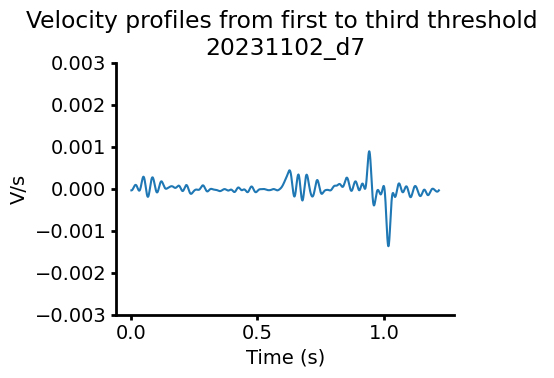

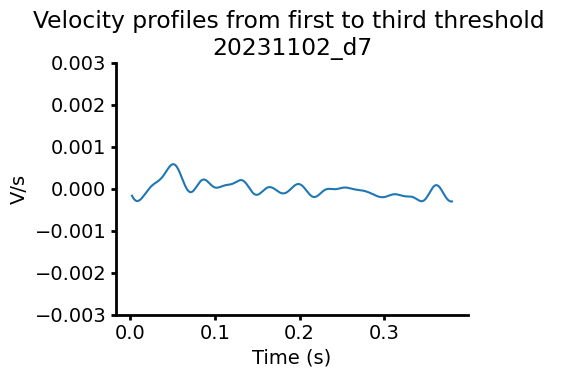

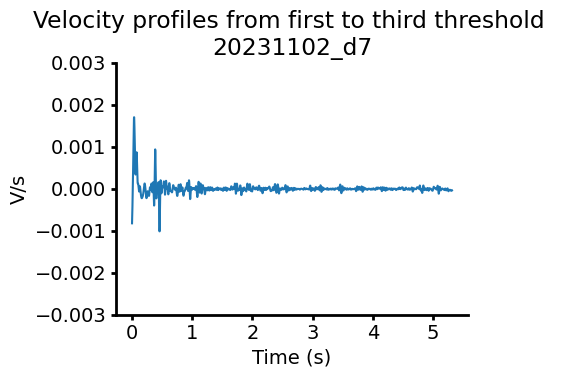

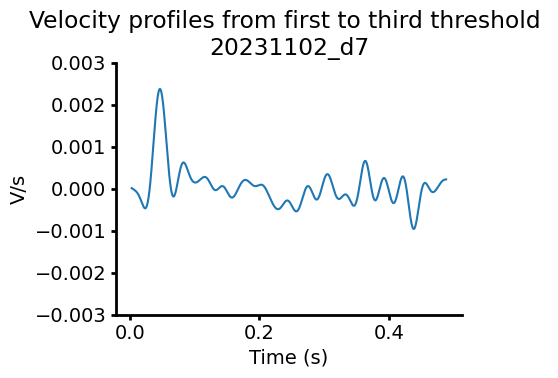

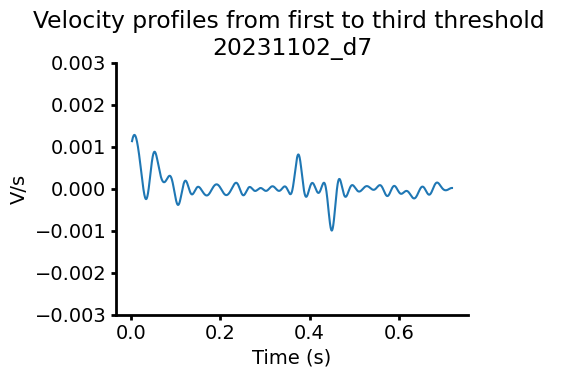

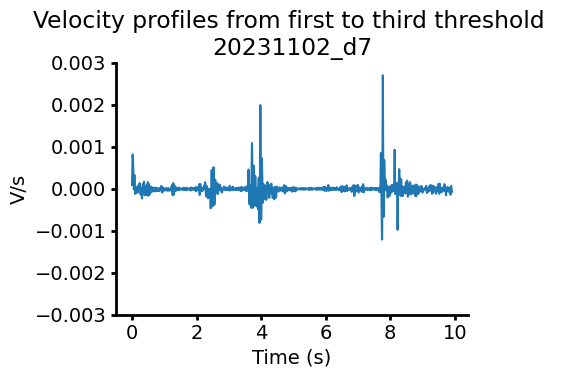

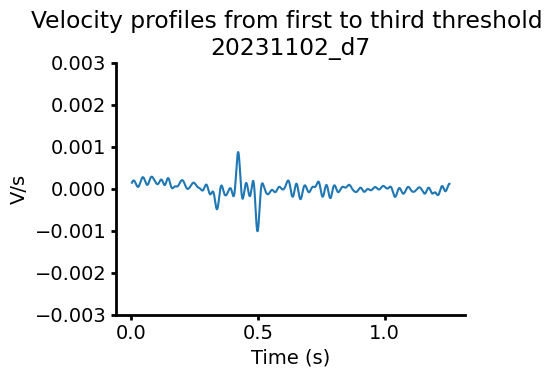

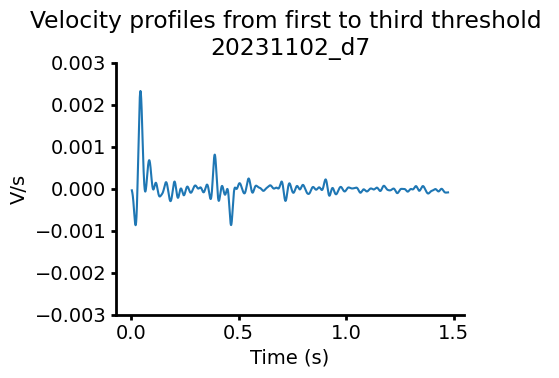

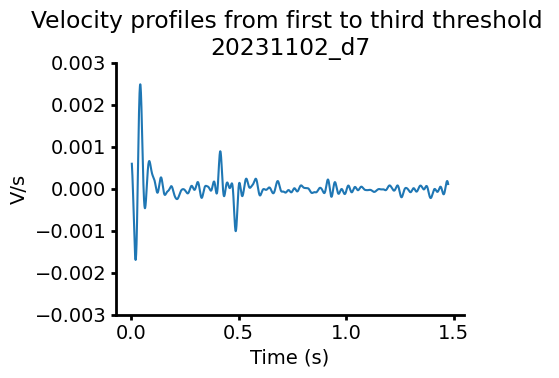

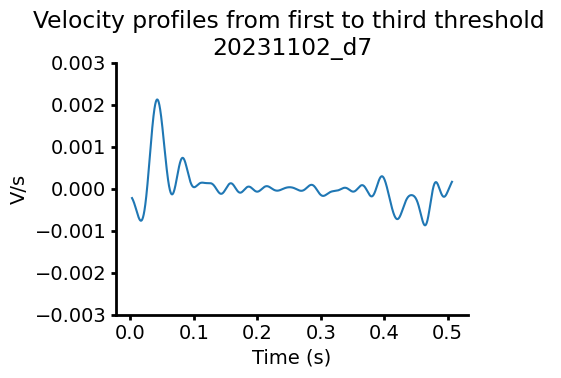

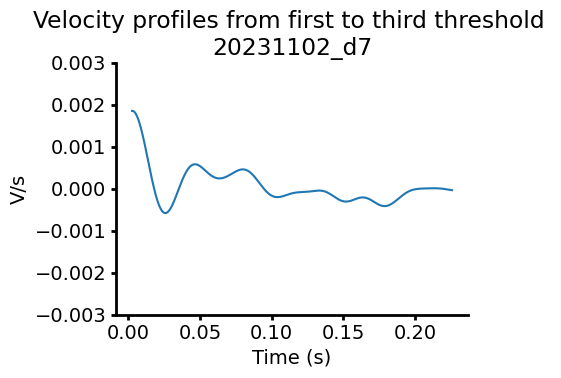

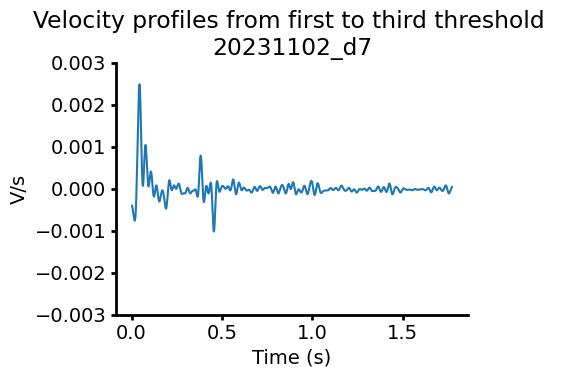

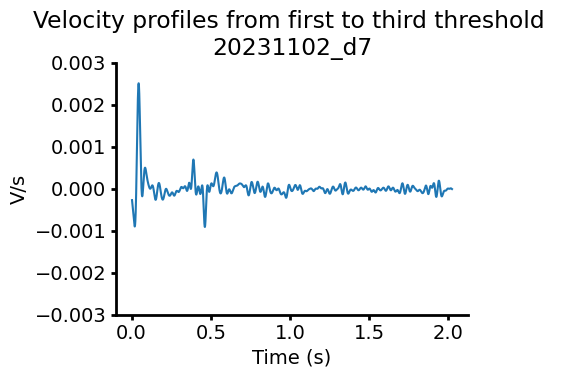

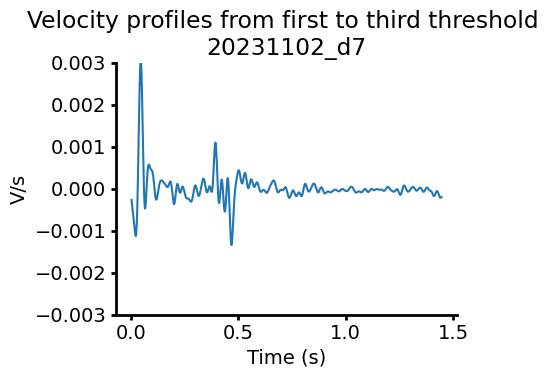

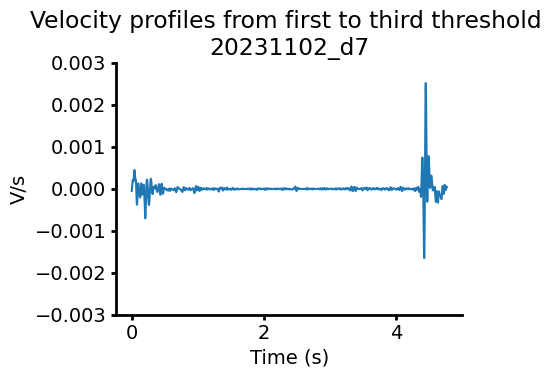

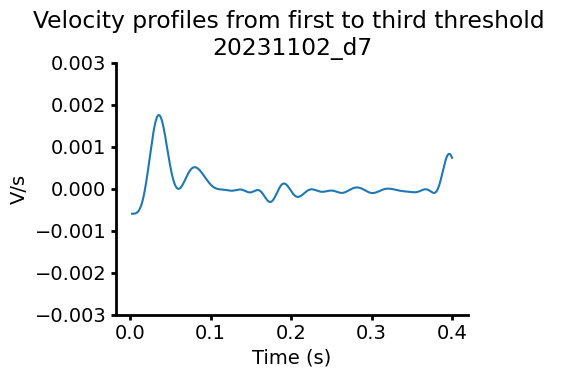

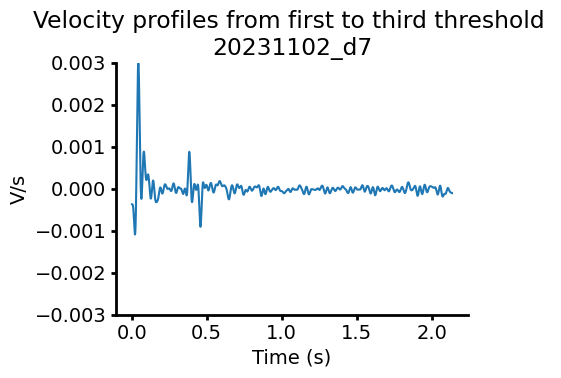

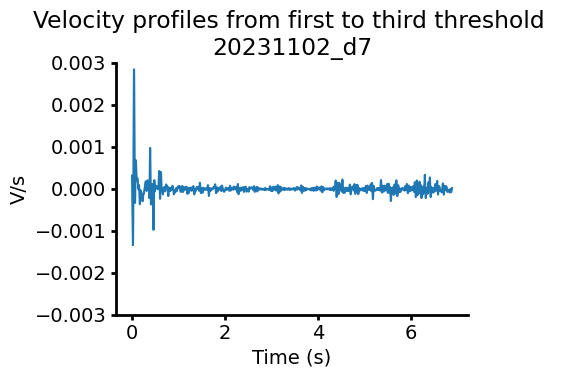

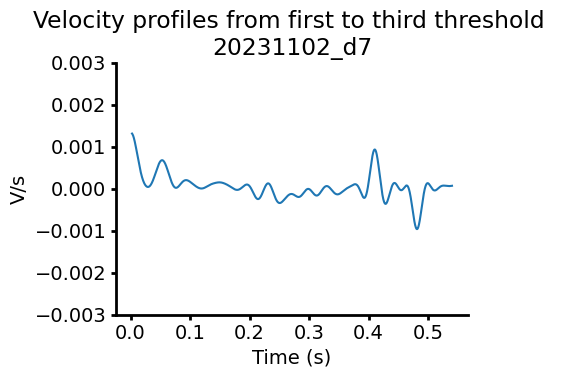

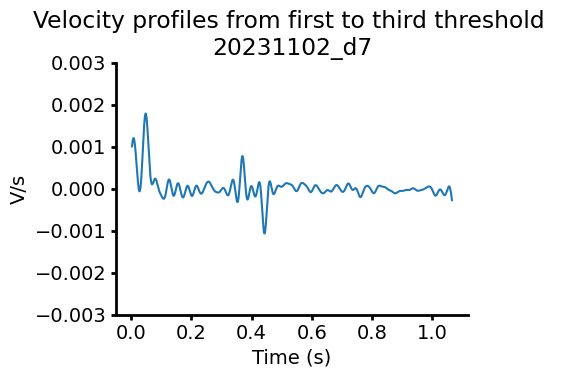

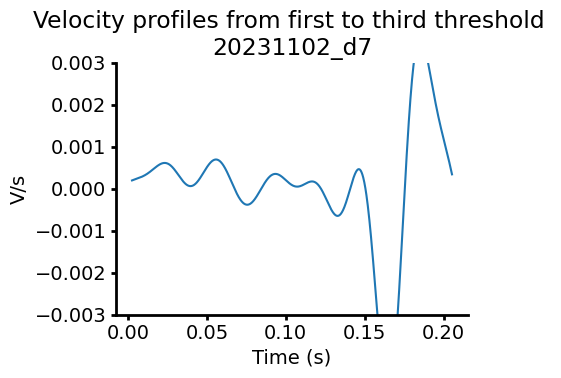

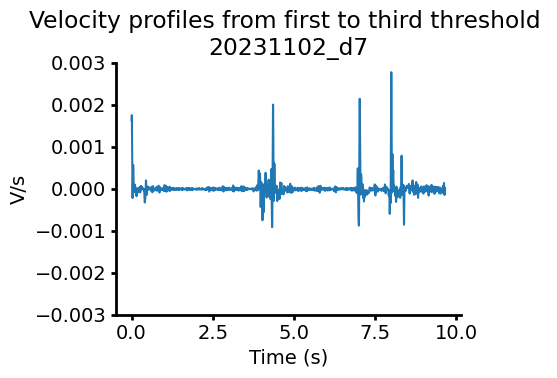

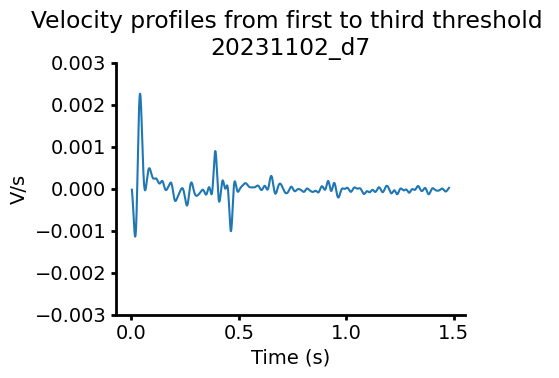

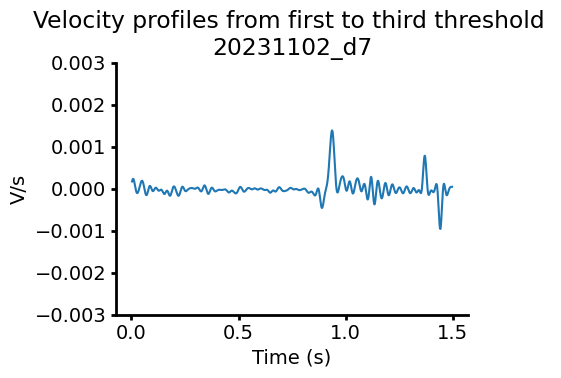

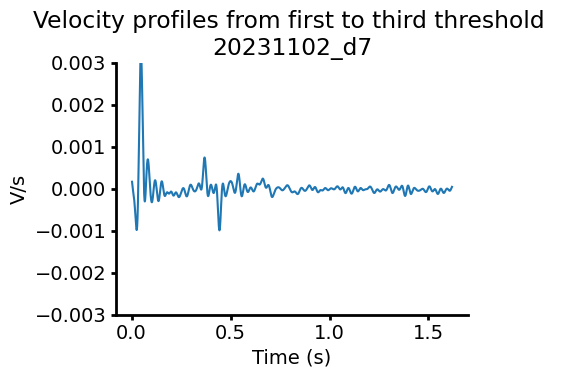

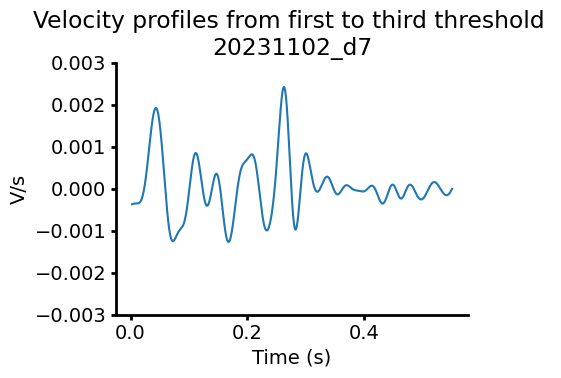

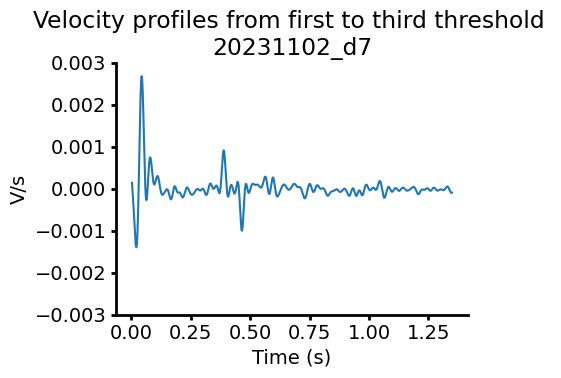

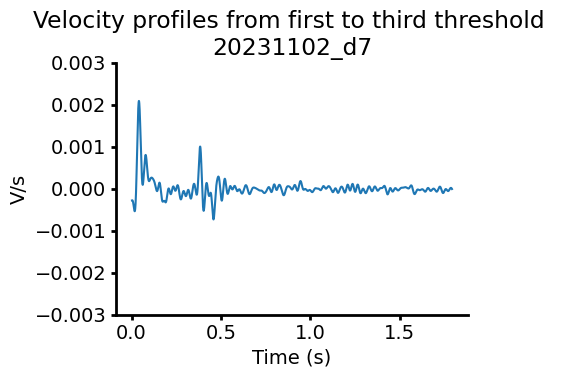

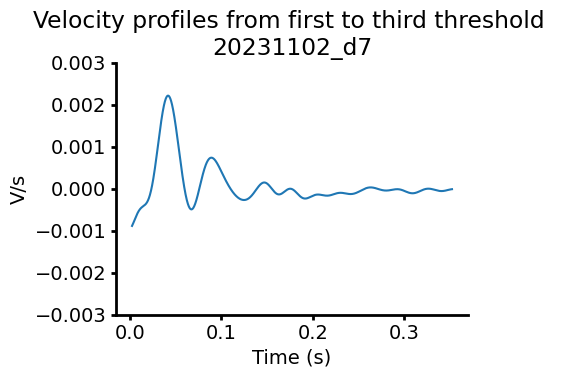

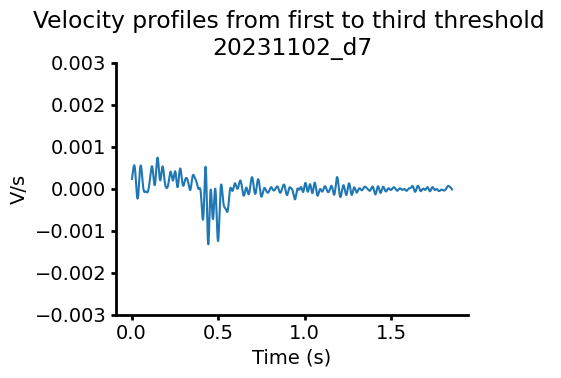

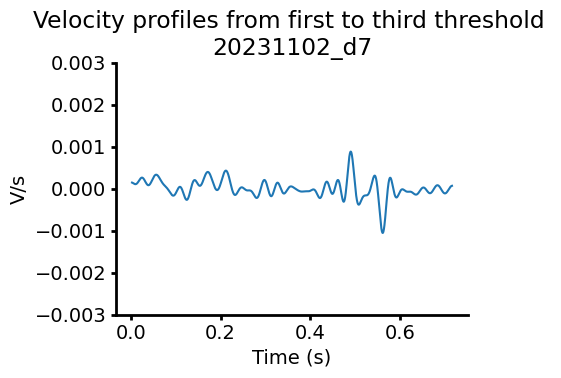

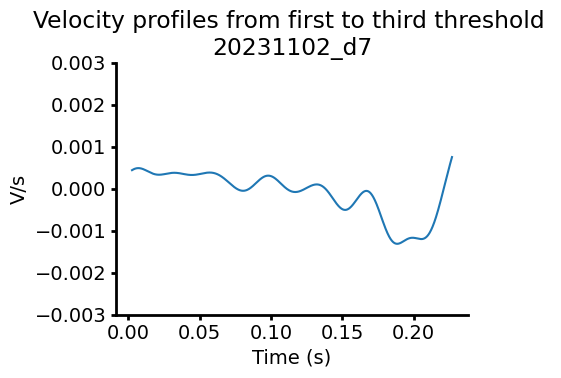

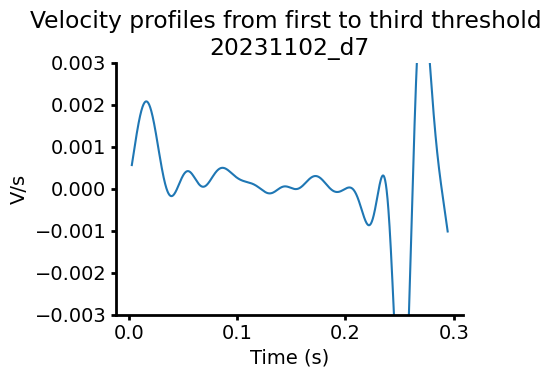

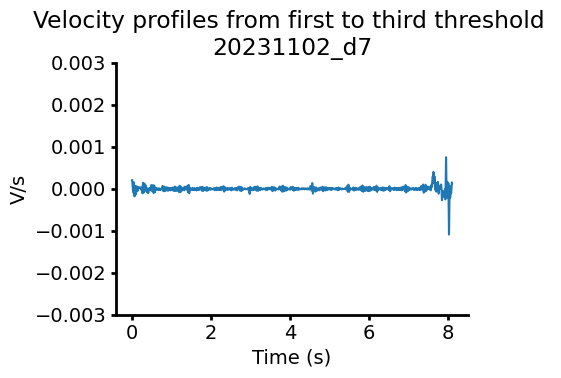

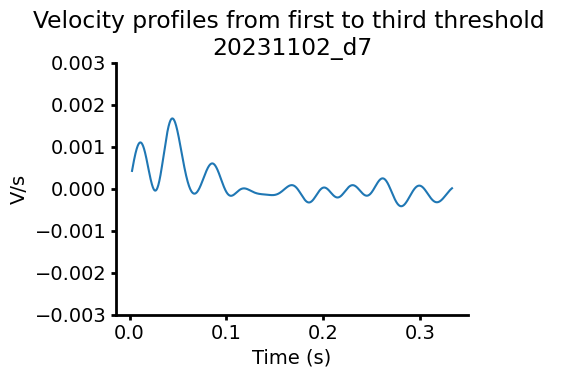

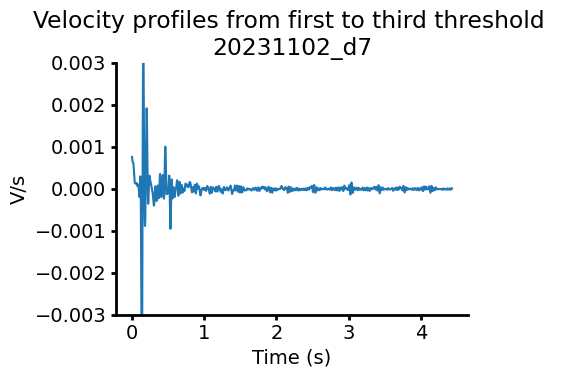

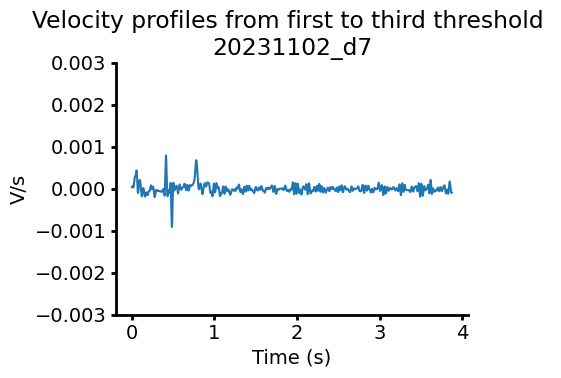

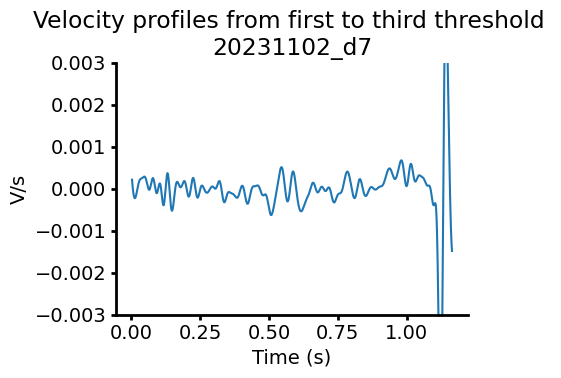

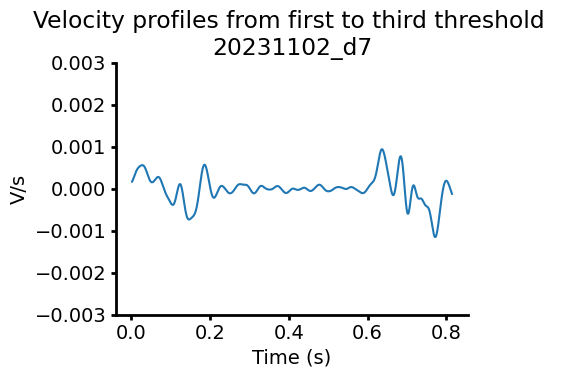

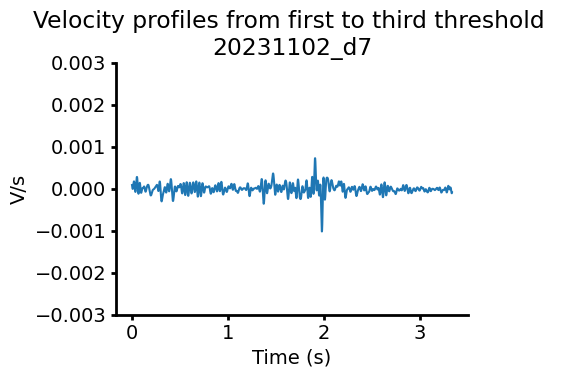

In [69]:
# loop through all movements from that day
num_samples = 10*10000
velocities_percent_scaled = np.array([]).reshape((0, num_samples))
for buffered_velocity_file in glob.glob(output_folder+'buffered_velocity_trial*.npy'):
    trial_i = int(re.search(r"(?<=trial).+?(?=\.npy)", buffered_velocity_file).group())
    buffered_velocity_data = np.load(buffered_velocity_file)

    # Read the binary file created by the C++ program which is saved as double
    trial_frequencies = np.fromfile(analysis0_folder+"trial_frequencies.bin", dtype=np.double)
    fs = trial_frequencies[trial_i]

    filtered = moving_average(buffered_velocity_data[1,:], 29)
    # get the moving average
    buffered_velocity_ma=np.vstack([buffered_velocity_data[0, 14:-14], filtered])
    np.save(output_folder+'buffered_velocity_ma_trial'+str(trial_i), buffered_velocity_ma)

    plt.plot(buffered_velocity_ma[0,:],buffered_velocity_ma[1,:])
plt.xlabel("Time (s)")
plt.ylabel("V/s")
plt.ylim([-0.003, 0.003])
plt.title("Velocity profiles from first to third threshold \n"+session)
plt.show()
    

### Make functions scaled from 0-100% of velocity path completion to analyze velocity path variability
These scaled 0-100% velocity path functions are made by linearly interpolating the original data at rates above sampling rate to make an approximate continuous function throughout the path. Right now, the `num_samples` = 10*10000 for a minimum sampling rate of 10kHz since __the velocities all take less than 10s__.

Save all of them together in `velocities_percent_scaled` and then into "velocities_percent_scaled.npy" file.

`velocities_percent_scaled`: rows are individual velocities, columns are samples (so left to right is going forward in time)

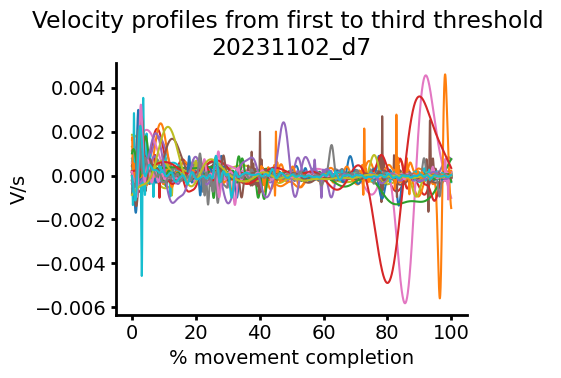

In [63]:
# loop through all movements from that day
num_samples = 10*10000
velocities_percent_scaled = np.array([]).reshape((0, num_samples))
for velocity_ma_file in glob.glob(output_folder+'buffered_velocity_ma_trial*.npy'):
    trial_i = int(re.search(r"(?<=trial).+?(?=\.npy)", velocity_ma_file).group())
    velocity_ma = np.load(velocity_ma_file)
    #velocity_ma=velocity_ma[:, 300-14:-300+14]

    percent_completion_x = np.linspace(0, 100, velocity_ma.shape[1])
    velocity_fcn = interpolate.interp1d(percent_completion_x, velocity_ma[1, :], kind='linear')
    new_x = np.linspace(0, 100, num_samples)
    new_y = velocity_fcn(new_x)
    velocities_percent_scaled = np.vstack([velocities_percent_scaled, new_y[:]])

    plt.plot(new_x,new_y)

plt.xlabel("% movement completion")
plt.ylabel("V/s")
plt.title("Velocity profiles from first to third threshold \n"+session)
plt.show()

### plot the mean velocity, `mean_v`, across each movement in `velocities_percent_scaled` across % movement completed
axis=0 runs downwards across rows

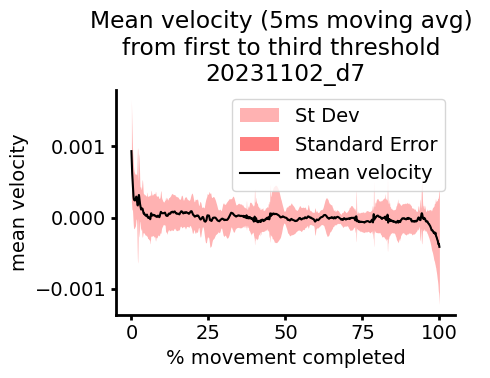

In [54]:
mean_v=np.mean(velocities_percent_scaled, axis=0)
var_v=np.var(velocities_percent_scaled, axis=0)

x_range = np.array(range(0,num_samples)) * 100 / num_samples
num_velocity_trials = len(glob.glob(output_folder+'buffered_velocity_ma_trial*.npy'))
std = np.sqrt(var_v)
standard_error = np.sqrt(var_v)/num_velocity_trials

plt.fill_between(x_range, mean_v+std, mean_v-std, color='red', alpha=0.3, label='St Dev', zorder=1, linewidth=0.0)
plt.fill_between(x_range, mean_v+standard_error, mean_v-standard_error, color='red', alpha=0.5, label='Standard Error', zorder=2, linewidth=0.0)
plt.plot(x_range, mean_v, label="mean velocity", zorder = 3, color='black')
plt.xlabel("% movement completed")
plt.ylabel("mean velocity")
plt.title("Mean velocity (5ms moving avg) \nfrom first to third threshold \n"+session)
plt.legend()
plt.show()